In [19]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [20]:
data = pd.read_csv("https://data.nasa.gov/api/views/dd9e-wu2v/rows.csv?accessType=DOWNLOAD")

In [21]:
data.columns = data.columns.str.strip()

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11033 entries, 0 to 11032
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   source_name                11033 non-null  object 
 1   source_link                10187 non-null  object 
 2   event_id                   11033 non-null  int64  
 3   event_date                 11033 non-null  object 
 4   event_time                 0 non-null      float64
 5   event_title                11033 non-null  object 
 6   event_description          10171 non-null  object 
 7   location_description       10931 non-null  object 
 8   location_accuracy          11031 non-null  object 
 9   landslide_category         11032 non-null  object 
 10  landslide_trigger          11010 non-null  object 
 11  landslide_size             11024 non-null  object 
 12  landslide_setting          10964 non-null  object 
 13  fatality_count             9648 non-null   flo

In [23]:
dum = pd.get_dummies(data["landslide_category"])
new_df = data.join(dum)

In [24]:
new_df = new_df.select_dtypes(exclude = "object")
new_df = new_df.drop(columns = ["event_id",
                                "event_time",
                                "longitude",
                                "latitude",
                                "event_import_id"
                                ],
                     axis =1)
new_df = new_df.dropna()

In [25]:
X = new_df[["fatality_count", "injury_count"]]
y = new_df.landslide

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.5)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [28]:
rfc = RandomForestClassifier()

params = {
    "n_estimators": [100, 1000, 1500],
    "criterion": ['gini', 'entropy'],
    "max_depth": [1, 5, 10],
    "max_features": ['auto', 'sqrt', 'log2'],
    "n_jobs": [-1],
    "random_state": [1]
}

In [29]:
grid = GridSearchCV(rfc, params).fit(X_train, y_train)
grid_df = pd.DataFrame(grid.cv_results_)

In [30]:
best_model = grid_df.loc[:"mean_test_score"].max()
best_model

mean_fit_time            2.1202
std_fit_time            1.81316
mean_score_time          1.2848
std_score_time         0.418005
param_criterion            gini
param_max_depth              10
param_max_features         sqrt
param_n_estimators         1500
param_n_jobs                 -1
param_random_state            1
split0_test_score      0.677835
split1_test_score      0.667526
split2_test_score      0.675258
split3_test_score      0.674419
split4_test_score      0.682171
mean_test_score         0.67286
std_test_score        0.0106293
rank_test_score              52
dtype: object

In [31]:
best_rfc = RandomForestClassifier(
    n_estimators = best_model.param_n_estimators,
    criterion = best_model.param_criterion,
    max_depth = best_model.param_max_depth,
    max_features = best_model.param_max_features,
    n_jobs = best_model.param_n_jobs,
    random_state = best_model.param_random_state,
).fit(X_train, y_train)

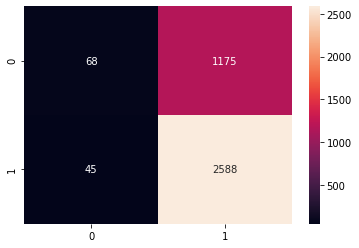

In [32]:
cm = confusion_matrix(y, best_rfc.predict(X))

sns.heatmap(cm, annot =True, fmt = 'd');

In [33]:
print(classification_report(y, best_rfc.predict(X)))


              precision    recall  f1-score   support

           0       0.60      0.05      0.10      1243
           1       0.69      0.98      0.81      2633

    accuracy                           0.69      3876
   macro avg       0.64      0.52      0.45      3876
weighted avg       0.66      0.69      0.58      3876



### Classifier that is not random forest

In [34]:
from sklearn.linear_model import SGDClassifier

In [35]:
sgd = SGDClassifier()

params = {
    "loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
    "penalty": ["l2", "l1", "elasticnet"],
    "fit_intercept": [True],
    "n_jobs" : [-1],
    "random_state" : [1],
    "learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
    "eta0" : [1],
}

In [36]:
grid = GridSearchCV(sgd, params).fit(X_train, y_train)
grid_df = pd.DataFrame(grid.cv_results_)

c:\users\natha\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [37]:
best_model = grid_df.loc[:"mean_test_score"].max()
best_model

mean_fit_time              0.0442869
std_fit_time               0.0360352
mean_score_time            0.0061758
std_score_time            0.00306454
param_eta0                         1
param_fit_intercept             True
param_learning_rate          optimal
param_loss             squared_hinge
param_n_jobs                      -1
param_penalty                     l2
param_random_state                 1
split0_test_score           0.680412
split1_test_score           0.675258
split2_test_score           0.675258
split3_test_score           0.674419
split4_test_score           0.674419
mean_test_score             0.674407
std_test_score              0.169165
rank_test_score                   59
dtype: object

In [38]:
best_sgd = SGDClassifier(
    loss = best_model.param_loss,
    penalty = best_model.param_penalty,
    fit_intercept = best_model.param_fit_intercept,
    n_jobs = best_model.param_n_jobs,
    random_state = best_model.param_random_state,
    learning_rate = best_model.param_learning_rate,
    eta0=best_model.param_eta0,
).fit(X_train, y_train)

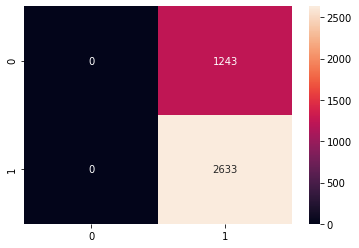

In [39]:
cm = confusion_matrix(y, best_sgd.predict(X))

sns.heatmap(cm, annot =True, fmt = 'd');